In [ ]:
import pandas as pd
import json
import sys
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import UnexpectedAlertPresentException

SCRIPT_DIR = os.path.dirname(os.path.abspath('../geometric_feature_extraction/feature_extraction.py'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

SCRIPT_DIR = os.path.dirname(os.path.abspath('../visualization_tools/plot_field.py'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from geometric_feature_extraction.feature_extraction import predict_from_name
from visualization_tools.plot_field import plot_field

In [ ]:
#NOTE np.matmul makes jupyter angry but works in python and idk why
import torch
np.matmul = lambda a,b : torch.matmul(torch.tensor(a), torch.tensor(b)).numpy()

In [16]:
with open('../data_collection/metadata.json','r') as f:
    metadata = json.load(f)

In [17]:
stadium = 'yankee_stadium'
metadata[stadium]['latitude'],metadata[stadium]['longitude']

(40.829638540977285, -73.92619595783125)

In [18]:
dodger_stadium, orientation = predict_from_name('truist_park', return_orientation=True)

In [19]:
np.degrees(orientation)

202.26827882991955

In [20]:
def convert_to_polar_function(points):
    x,y = points[:,0], points[:,1]
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    # Ensure theta is in [0, 2*pi] range
    theta = (theta + 2 * np.pi) % (2 * np.pi)

    # Sort by angle to ensure the function is well-defined
    sorted_indices = np.argsort(theta)
    theta_sorted = theta#[sorted_indices]
    r_sorted = r#[sorted_indices]
    # Interpolate r as a function of theta
    # Use 'linear', 'quadratic', 'cubic' or other methods for smoothness
    r_function = interp1d(theta_sorted, r_sorted, kind='linear', fill_value="extrapolate")
    return r_function               

dodger_polar = convert_to_polar_function(dodger_stadium)

In [21]:
def est_polar_area(f, a, b, sample_size=10000):
    x = np.linspace(a, b, sample_size)
    y = f(x)
    return sum(y**2)/2 * (b-a) / sample_size

def est_polar_avg_value(f, a, b, sample_size=10000):
    x = np.linspace(a, b, sample_size)
    y = f(x)
    return sum(y) /sample_size

In [22]:
def get_wind(lat, long):
    wind = {}
    uwind = pd.read_csv('uwind.csv')
    vwind = pd.read_csv('vwind.csv')
    uwind.loc[uwind['lon']>180,'lon'] = 360 - uwind.loc[uwind['lon']>180,'lon']
    vwind.loc[vwind['lon']>180,'lon'] = 360 - vwind.loc[vwind['lon']>180,'lon']
    udist = (uwind['lat'] - lat)**2 + (uwind['lon'] - long)**2
    vdist = (vwind['lat'] - lat)**2 + (vwind['lon'] - long)**2
    wind['u_wind'] = uwind.loc[udist.argmin(),'uwnd']
    wind['v_wind'] = vwind.loc[vdist.argmin(),'vwnd']
    return wind

In [29]:
def get_weather(lat, long):
    weather = pd.read_csv('temp.csv')
    weather.loc[weather['lon']>180,'lon'] = 360 - weather.loc[weather['lon']>180,'lon']
    dist = (weather['lat'] - lat)**2 + (weather['lon'] - long)**2
    
    return weather.loc[dist.argmin(),'tmp']


In [35]:
def get_elevation_by_name(park_name):
    elv = pd.read_csv('elv.csv')
    return elv.loc[elv['ballpark']==park_name, 'elevation'].iloc[0]


In [49]:
def feature_engineering(park_name, polar_func, latitude, longitude, orientation):
    features = {'orientation':orientation}
    features['lf_depth'] = float(polar_func(3*np.pi/4))
    features['lc_depth'] = float(polar_func(5*np.pi/8))
    features['cf_depth'] = float(polar_func(np.pi/2))
    features['rc_depth'] = float(polar_func(3*np.pi/8))
    features['rf_depth'] = float(polar_func(np.pi/4))
    features['lf_area'] = est_polar_area(polar_func, 0.25*np.pi, 0.35*np.pi)
    features['lc_area'] = est_polar_area(polar_func, 0.35*np.pi, 0.45*np.pi)
    features['cf_area'] = est_polar_area(polar_func, 0.45*np.pi, 0.55*np.pi)
    features['rc_area'] = est_polar_area(polar_func, 0.55*np.pi, 0.65*np.pi)
    features['rf_area'] = est_polar_area(polar_func, 0.65*np.pi, 0.75*np.pi)
    features['total_area'] = est_polar_area(polar_func, 0.25*np.pi, 0.75*np.pi)
    features['avg_depth'] = est_polar_avg_value(polar_func, 0.25*np.pi, 0.75*np.pi)
    features['temp_K'] = get_weather(latitude, longitude)
    features.update(get_wind(latitude, longitude))
    features['out_to_cf_wind'] = features['u_wind'] * np.cos(orientation) + features['v_wind'] * np.sin(orientation)
    features['left_to_right_wind'] = features['u_wind'] * np.sin(orientation) - features['v_wind'] * np.cos(orientation)
    try:
        features['elevation_m'] = get_elevation_by_name(park_name)
    except:
        features['elevation_m'] = get_elevation_meters([(latitude, longitude)])[0]
        
    return features

In [25]:
import time

In [26]:
def get_elevation_meters(coords):
    output = []
    options = webdriver.ChromeOptions()
    # options.add_argument("--headless")  # Optional: run in headless mode
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get('https://www.dcode.fr/earth-elevation')
        #textbox = driver.find_element(By.ID, 'earth_elevation_calculator_gps')
    i = 0
    while i < len(coords):
        try:
            lat, long = coords[i]
            textbox = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.ID, 'earth_elevation_calculator_gps')))
            fstring = f'({lat}, {long})'
            textbox.send_keys(fstring)
            button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.ID, 'earth_elevation_calculator'))).find_element(By.TAG_NAME, 'button')
            #     button = driver.find_element(By.ID, 'earth_elevation_calculator')
            button.click()
            result = WebDriverWait(driver, 10).until(
                    EC.visibility_of_element_located((By.CLASS_NAME, 'result')))
            output.append(int(result.text))
            textbox.send_keys('\b'*len(fstring))
            i += 1
            time.sleep(10)
        except UnexpectedAlertPresentException:
            input()
        except Exception:
            return output, i
    return output
    

In [31]:
get_weather(metadata[stadium]['latitude'],metadata[stadium]['longitude'])

287.1756

In [36]:
stadium = 'yankee_stadium'
pts, ori = predict_from_name(stadium ,return_orientation=True)
func = convert_to_polar_function(pts)
feature_engineering(stadium, func,metadata[stadium]['latitude'],metadata[stadium]['longitude'], ori)

{'orientation': 4.9664599053507885,
 'lf_depth': 321.4959913570829,
 'lc_depth': 378.88519147116074,
 'cf_depth': 409.9161795702694,
 'rc_depth': 353.3286305573141,
 'rf_depth': 310.8847711806694,
 'lf_area': 17130.246149896364,
 'lc_area': 21287.107486957484,
 'cf_area': 26192.759724280444,
 'rc_area': 24318.223589027675,
 'rf_area': 19389.063145612596,
 'total_area': 108314.55770367415,
 'avg_depth': 370.09919162099845,
 'temp_K': 287.1756,
 'u_wind': 0.47220573,
 'v_wind': -0.1683339,
 'out_to_cf_wind': 0.28161706402391873,
 'left_to_right_wind': -0.41473652188418486,
 'elevation_m': 4}

In [39]:
features = {}

all_parks = pd.read_csv('all_park_factors.csv')

for i, row in all_parks.iterrows():
    try:
        stadium = row['ballpark']
        pts, ori = predict_from_name(stadium ,return_orientation=True)
        func = convert_to_polar_function(pts)
        features[stadium] = feature_engineering(stadium, func,metadata[stadium]['latitude'],metadata[stadium]['longitude'], ori)
    except:
        pass

c:\Users\mccap\OneDrive\Documents\Baseball\field_plot\geometric_feature_extraction\feature_extraction.py:91: RuntimeWarning: Mean of empty slice.
  return tuple(np.argwhere(a).mean(axis=0))
c:\Users\mccap\anaconda3\envs\field-plot-env\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\Users\mccap\OneDrive\Documents\Baseball\field_plot\geometric_feature_extraction\feature_extraction.py:91: RuntimeWarning: Mean of empty slice.
  return tuple(np.argwhere(a).mean(axis=0))
c:\Users\mccap\anaconda3\envs\field-plot-env\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\Users\mccap\OneDrive\Documents\Baseball\field_plot\geometric_feature_extraction\feature_extraction.py:91: RuntimeWarning: Mean of empty slice.
  return tuple(np.argwhere(a).mean(axis=0))
c:\Users\mccap\anaconda3\envs\field-plot-env\lib\site-packages\numpy\core\_methods.py:

In [47]:
def feature_from_name(stadium):
        pts, ori = predict_from_name(stadium ,return_orientation=True)
        func = convert_to_polar_function(pts)
        print(metadata[stadium]['latitude'],metadata[stadium]['longitude'])
        return feature_engineering(stadium, func,metadata[stadium]['latitude'],metadata[stadium]['longitude'], ori)

In [50]:
feature_from_name('millville_high_school_baseball_field')

39.40108129980312 -75.02015290457305


{'orientation': 3.9892090041183574,
 'lf_depth': 310.1329209729035,
 'lc_depth': 326.4786164250165,
 'cf_depth': 336.41000970438546,
 'rc_depth': 330.1228612756279,
 'rf_depth': 308.6409102337052,
 'lf_area': 15973.35414745675,
 'lc_area': 17147.239045477865,
 'cf_area': 17520.83707989633,
 'rc_area': 16659.150026376956,
 'rf_area': 15696.047321129501,
 'total_area': 82995.86249942267,
 'avg_depth': 324.98920286974555,
 'temp_K': 287.1756,
 'u_wind': -0.14962485,
 'v_wind': -0.022247849,
 'out_to_cf_wind': 0.11569687091565625,
 'left_to_right_wind': 0.09745150887993102,
 'elevation_m': 12}

In [44]:
features_df = pd.DataFrame(features).T
features_df.to_csv('features.csv')

In [35]:
get_elevation_meters([(metadata[stadium]['latitude'],metadata[stadium]['longitude']) for stadium in ['yankee_stadium','dodger_stadium']])

[11, 152]

In [27]:
all_parks = pd.read_csv('all_park_factors.csv')

In [40]:
elevations = get_elevation_meters([(metadata[stadium]['latitude'],metadata[stadium]['longitude']) for stadium in all_parks['ballpark'].values.tolist()])

In [42]:
elevations_df = all_parks[['ballpark']].copy()
elevations_df['elevation'] = elevations
elevations_df.to_csv('elv.csv')

In [18]:
import requests
import pandas as pd
from datetime import datetime, timedelta
# Function to get weather data from OpenWeatherMap
def get_weather_data(lat, lon, dt, api_key):
    url = f"https://api.openweathermap.org/data/2.5/weather"#?lat={lat}&lon={lon}&appid={API key}
    params = {
        'lat': lat,
        'lon': lon,
        'date': dt,  # Use a timestamp (epoch) here
        'appid': api_key,
        'units': 'metric',  # Metric system (Celsius)
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        
        return {k:v for k,v in data['main'].items()}
    else:
        print(f"Error fetching data for {lat}, {lon}: {response.status_code}")
        print(response.text)
        return None

# Example usage
api_key = '14294c9a350bfdc763da08cf9b0cf53a'  # Replace with your actual API key
start_date = '2024-01-01'
end_date = '2024-12-31'

# List of coordinates (lat, lon)
all_parks = pd.read_csv('all_park_factors.csv')

start_date = datetime(2024, 1, 1)
weather = []
for i in range(366):
    print(i)
    dt = (start_date + timedelta(i)).strftime('%Y-%m-%d')
    for ballpark in all_parks['ballpark'].values.tolist():
        lat = metadata[ballpark]['latitude']
        long = metadata[ballpark]['longitude']
        weather.append( get_weather_data(lat, long, dt, api_key))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
Error fetching data for 40.829638540977285, -73.92619595783125: 429
{"cod":429, "message": "Your account is temporary blocked due to exceeding of requests limitation of your subscription type. Please choose the proper subscription https://openweathermap.org/price"}
Error fetching data for 39.28381877998954, -76.62168062124314: 429
{"cod":429, "message": "Your account is temporary blocked due to exceeding of requests limitation of your subscription type. Please choose the proper subscription https://openweathermap.org/price"}
Error fetching data for 41.82987685997236, -87.63365767408031: 429
{"cod":429, "message": "Your account is temporar

KeyboardInterrupt: 

{'orientation': 4.9664599053507885,
 'lf_depth': 321.4959913570829,
 'lc_depth': 378.88519147116074,
 'cf_depth': 409.9161795702694,
 'rc_depth': 353.3286305573141,
 'rf_depth': 310.8847711806694,
 'lf_area': 17130.246149896364,
 'lc_area': 21287.107486957484,
 'cf_area': 26192.759724280444,
 'rc_area': 24318.223589027675,
 'rf_area': 19389.063145612596,
 'total_area': 108314.55770367415,
 'avg_depth': 370.09919162099845,
 'u_wind': 0.47220573,
 'v_wind': -0.1683339,
 'out_to_cf_wind': 0.28161706402391873,
 'left_to_right_wind': -0.41473652188418486}

In [15]:
0.47220573**2+0.1683339**2

0.2513145533340429

In [16]:
0.28161706402391873**2+0.41473652188418486**2

0.2513145533340429

: 

In [49]:
150**2*np.pi/2 - 108288.24178274402

-72945.32442985885

[232.10705849 238.3735849 ] [232.10705849 238.37350999]
232.107058712314
[229.23334803 234.23227814] [229.23334803 234.23235174]
229.23334795436924


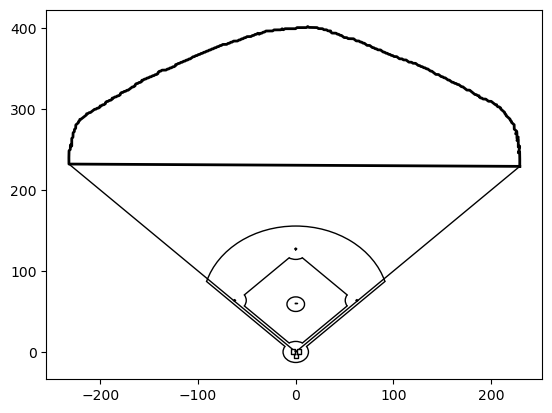

In [28]:
theta = np.linspace(np.pi*.25, .75*np.pi,10000000)
r = dodger_polar(theta)
x = r * np.cos(theta)
y = r * np.sin(theta)
dodger_cartesian = np.column_stack([x,y])
plot_field(dodger_cartesian)

[226.11770063 228.6391227 ] [227.33199561 227.33199561]
227.33199561288586
[221.14874342 218.59547234] [218.53448925 221.02406232]
219.82510553496377


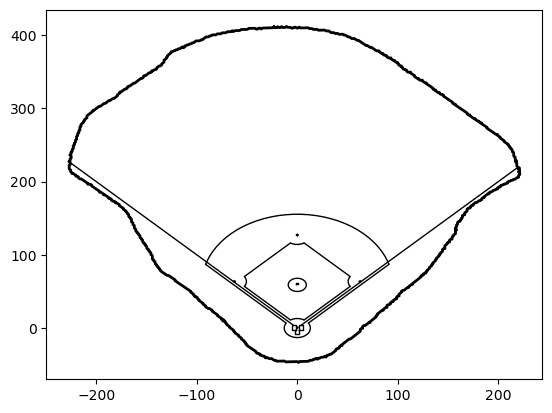

In [29]:
yankee_stadium = predict_from_name('yankee_stadium')
yankee_polar = convert_to_polar_function(yankee_stadium)
theta = np.linspace(0, 2*np.pi,1000000)
r = yankee_polar(theta)
x = r * np.cos(theta)
y = r * np.sin(theta)
yankee_cartesian = np.column_stack([x,y])
plot_field(yankee_stadium)

In [6]:
raise Exception("don't accidentally run the next part")

Exception: don't accidentally run the next part

In [1]:
#NOTE numpy 1.21 to get this working

from ftplib import FTP
import xarray
import io
ftp = FTP('ftp.cdc.noaa.gov')
ftp.login()
ftp.cwd('/Datasets/ncep.reanalysis2.dailyavgs/gaussian_grid/')
files = ftp.nlst()

In [12]:
with io.BytesIO() as f:
    ftp.retrbinary(f'RETR vwnd.10m.gauss.2024.nc', f.write)
    wind_df = xarray.open_dataset(f).to_dataframe()

In [2]:
with io.BytesIO() as f:
    ftp.retrbinary(f'RETR tmp.10-200cm.gauss.2024.nc', f.write)
    temp_df = xarray.open_dataset(f).to_dataframe()

In [10]:
temp_df.reset_index().groupby(['lat','lon'])['tmp'].mean().reset_index().dropna().to_csv('temp.csv', index=False)

In [3]:
ftp.close()

In [14]:
wind_df.reset_index().groupby(['lat','lon'])['vwnd'].mean().to_csv('vwind.csv')

In [1]:
import numpy as np
np.__version__

'1.24.3'

In [ ]:
feature_engineering('millville')